## Timberland Topic Modeling Analysis 

### Using advance clustering techniques to segment amazon.com review data for Timberland.

In [1]:
from time import sleep


#### First we will load all clothing, shoes, and jewelery scarpped from amazon.com. 

In [ ]:
count = 0

loadedjson = open('meta_Clothing_Shoes_and_Jewelry.json', 'r')

allproducts = {}
listofcategories = {}

for aline in loadedjson:
    count += 1
    if count % 100000 == 0:
        print(count)
    aproduct = eval(aline)
    
    allproducts[aproduct['asin']] = aproduct
    
    for categories in aproduct['categories']:
        for acategory in categories:
            if acategory in listofcategories:
                listofcategories[acategory] += 1
            if acategory not in listofcategories:
                listofcategories[acategory] = 1

100000
200000
300000
400000
500000


### Next we will run a for loop the data and create a list of Asins that are only associated with Timberland products.

In [ ]:
#############  Segment Data to Find Timberland Asins ##########
                           
count = 0 
allTimbasins = set()    

for aproduct in allproducts:
    theproduct = allproducts[aproduct]
    count += 1
    if count % 100000 == 0:
        print(count/1503384)
    for categories in theproduct['categories']:
        for acategory in categories:
            if 'timberland' in acategory.lower():
                allTimbasins.add(theproduct['asin'])

listOfTimbAsins = list(allTimbasins)

len(allTimbasins)

### Next using our Timberland Asins, we will go through the amazon reviews and create a list of only reviews that have a Timberland Asin.

In [ ]:
loadedjson = open('reviews_Clothing_Shoes_and_Jewelry.json', 'r')
allreviews = {}

count = 0

for aline in loadedjson:
    count += 1
    if count % 100000 == 0:
        print(count)
    areview= eval(aline)
    theasin = areview['asin']
    thereviewer = areview['reviewerID']
    
    if theasin in allTimbasins:
        thekey = '%s.%s' % (theasin, thereviewer)
        allreviews[thekey] = areview
        
len(allreviews)

#### Load all packeges necessary for analysis as well as all english stopwords (common words that we gain no insight from e.g. "the").

In [2]:
################# Segment the review text looking for stop words and english Language ##############


import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from googletrans import Translator
from time import sleep
from scipy.spatial.distance import euclidean
from textblob import TextBlob
import langid as lid
import goslate

allreviews = json.load(open('allTimbReviews.json', 'r'))
len(allreviews)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/coba0851/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


28326

#### Ad "timberland" to our stopword list as it will appear in many of the reviews but we can not gain any insight from.

#### Create function that goes through each element of a list, and through a nested dictionary with each aspect of a amazon review (stars, reviewers profile, review text, etc.)  is a key in the dictionary and specifcally looks for reviewText key and appends that to a set.

In [3]:
stop_words = stopwords.words('english')
stop_words.append('timberland')

import langid as lid

texts = set()
def load_texts(topicdata):
    for areview in topicdata:
        if 'reviewText' in topicdata[areview]:
            reviewtext =  topicdata[areview]['reviewText']
            lan,score = lid.classify(reviewtext)
            if lan == 'en':
                summary =  topicdata[areview]['summary']
                asin =  topicdata[areview]['asin']
                review = '%s %s %s' % (asin, summary, reviewtext)
                texts.add(review)

### Load Texts

In [4]:
print('loading texts')         
load_texts(allreviews)   

documents = list(texts)

vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(documents)

loading texts


###3 Using k-means method, create clusters from the Timberland reviews.

In [5]:
from sklearn.cluster import KMeans


true_k = 15

model = KMeans(n_clusters=true_k, max_iter= 100000)
model.fit(X)

order_centroids = model.cluster_centers_.argsort()[:,::-1]

terms = vectorizer.get_feature_names()

for i in range(true_k):
    topic_terms = [terms[ind] for ind in order_centroids[i, :4]]
    print('%d: %s' % (i, ' '.join(topic_terms)))

0: good quality price boots
1: boots great love comfortable
2: shoes comfortable great fit
3: boot great boots comfortable
4: pair boots years second
5: sandals b005fi1ve6 sandal great
6: great boots comfortable like
7: socks wear thick boots
8: size small boots ordered
9: stars five four good
10: shoe great comfortable shoes
11: steel toe boots work
12: 34 boots boot fit
13: best ever boots owned
14: excellent quality boots product


#### Creeat directory with the clusters as topic segment and place each timberland review to its approriate segment.  From here deep dive in the segments and look at the texts to gain insight on Timberlands product and what people are saying about it.  From herewe can look at the segments topics as well as the reviews in the segments and change the amount of clusters to the optimal amount.

In [6]:
import os
outfiles = {} 

try:
    os.mkdir('output')

except OSError:
    print('directory already exsists')

else:
    print('Successfully created the directory')
    
for atopic in range(true_k):
    topicterms = [terms[ind] for ind in order_centroids[atopic, :4]]
    outfiles[atopic] = open(os.path.join('output', '_'.join(topicterms) + '.txt'), 'w')
    
for areview in allreviews:
    if 'reviewText' in allreviews[areview]:
        thereview = allreviews[areview]
        reviewwithmetadata = '%s %s %s' % (thereview['asin'], thereview['summary'], thereview['reviewText'])
        Y = vectorizer.transform([reviewwithmetadata])
   
        for prediction in model.predict(Y):
            outfiles[prediction].write('%s\n' % reviewwithmetadata)
            
for n, f in outfiles.items():
    f.close()

Successfully created the directory


### Elbow plot to determine optimal amount of clusters

#### Another method to determine the optimal amount of clusters is the elbow method, where we plot the the number of clusters (K) against the WCSS (Within cluster some of squares). The goal of cluster analysis is to try and minimize the distance in clusters and maxmize the distance between cluters.  The elbow method hopefully shows a kink or "elbow" where the optimal-K is.  Based on our plot though there seems to be no elbow.  The only two points that have any sort of kink are at k= 2 and k=6. It may be more efficent to use other methods to determine the optimal amount of clusters.

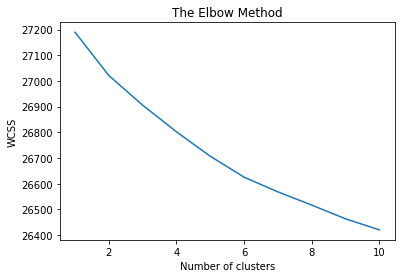

In [7]:
##### Elbow meethod Graph ######
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

### The graph shows that there is no elbow or kink and thus thus use other methods such as exploring the reviews in the segments and seeing if their placement makes sence (Actionable, substaional and differentiable). 